<a href="https://colab.research.google.com/github/syhr0110/myproject/blob/main/FL_communication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Client data division:
Client1: Number of samples: 12000
Distribution: {0: 1206, 1: 1351, 2: 1176, 3: 1228, 4: 1184, 5: 1048, 6: 1208, 7: 1279, 8: 1127, 9: 1193}
Client2: Number of samples: 12000
Distribution: {0: 1175, 1: 1381, 2: 1171, 3: 1259, 4: 1163, 5: 1096, 6: 1162, 7: 1210, 8: 1165, 9: 1218}
Client3: Number of samples: 12000
Distribution: {0: 1153, 1: 1381, 2: 1195, 3: 1203, 4: 1160, 5: 1086, 6: 1197, 7: 1232, 8: 1180, 9: 1213}
Client4: Number of samples: 12000
Distribution: {0: 1195, 1: 1357, 2: 1220, 3: 1199, 4: 1148, 5: 1094, 6: 1181, 7: 1247, 8: 1181, 9: 1178}
Client5: Number of samples: 12000
Distribution: {0: 1194, 1: 1272, 2: 1196, 3: 1242, 4: 1187, 5: 1097, 6: 1170, 7: 1297, 8: 1198, 9: 1147}


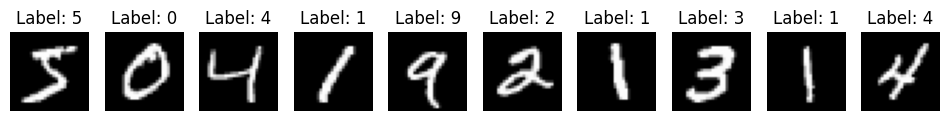


 === Round 1 ===
 [Client 1] parameters:
 conv1.weight: mean=0.0325, std=0.2395
 conv1.bias: mean=0.0437, std=0.1856
 conv2.weight: mean=-0.0018, std=0.0388
 conv2.bias: mean=-0.0268, std=0.0425
 fc1.weight: mean=0.0002, std=0.0122
 fc1.bias: mean=0.0047, std=0.0139
 fc2.weight: mean=0.0014, std=0.1002
 fc2.bias: mean=0.0051, std=0.0778
 [Client 2] parameters:
 conv1.weight: mean=0.0554, std=0.2327
 conv1.bias: mean=-0.0243, std=0.1846
 conv2.weight: mean=-0.0008, std=0.0388
 conv2.bias: mean=-0.0300, std=0.0448
 fc1.weight: mean=0.0002, std=0.0123
 fc1.bias: mean=0.0031, std=0.0142
 fc2.weight: mean=0.0006, std=0.1031
 fc2.bias: mean=0.0040, std=0.0764
 [Client 3] parameters:
 conv1.weight: mean=0.0613, std=0.2254
 conv1.bias: mean=-0.0546, std=0.1557
 conv2.weight: mean=-0.0007, std=0.0387
 conv2.bias: mean=-0.0286, std=0.0504
 fc1.weight: mean=0.0000, std=0.0124
 fc1.bias: mean=0.0035, std=0.0127
 fc2.weight: mean=0.0012, std=0.1018
 fc2.bias: mean=0.0041, std=0.0837
 [Client 4] pa

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import copy
import numpy as np
import matplotlib.pyplot as plt

# Load data
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Set clients
num_clients = 5
data_per_client = len(mnist_data) // num_clients

# Split data(IID)
client_datasets = [Subset(mnist_data, range(i * data_per_client, (i + 1) * data_per_client)) for i in range(num_clients)]
client_loaders = [DataLoader(client_datasets[i], batch_size=32, shuffle=True) for i in range(num_clients)]
client_data_sizes = [len(dataset) for dataset in client_datasets]

# Visual client data
print("Client data division:")
for i in range(num_clients):
    labels = [mnist_data.targets[idx] for idx in client_datasets[i].indices]
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"Client{i+1}: Number of samples: {len(client_datasets[i])}")
    print(f"Distribution: {dict(zip(unique_labels, counts))}")

def visualize_client_data(client_idx, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for i in range(num_images):
        image, label = mnist_data[client_datasets[client_idx].indices[i]]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()
visualize_client_data(client_idx=0)

# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train model
def train_local_model(model, dataloader, epochs=1):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for data, target in dataloader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

    return model.state_dict()

# Server aggregation (FedAvg)
def federated_averaging(client_weights, client_data_sizes):
    total_data = sum(client_data_sizes)
    global_model = copy.deepcopy(client_weights[0])

    for key in global_model.keys():
        global_model[key] = torch.stack([
            client_weights[i][key] * (client_data_sizes[i] / total_data)
            for i in range(len(client_weights))
        ]).sum(dim=0)

    return global_model

# FL training
global_model = CNN()
client_models = [CNN() for _ in range(num_clients)]
rounds = 2

for r in range(rounds):
    print(f"\n === Round {r+1} ===")
    client_weights = []
    before_fedavg_params = {name: param.clone().detach() for name, param in global_model.named_parameters()}

    for i in range(num_clients):
        local_weights = train_local_model(client_models[i], client_loaders[i], epochs=1)
        client_weights.append(local_weights)
        print(f" [Client {i+1}] parameters:")
        for name, param in local_weights.items():
            print(f" {name}: mean={param.mean().item():.4f}, std={param.std().item():.4f}")

    # FedAvg
    global_weights = federated_averaging(client_weights, client_data_sizes)

    # Update globalmodel
    global_model.load_state_dict(global_weights)

    print("\n Global model parameters:")
    for name, param in global_model.state_dict().items():
      print(f"{name}: mean={param.mean().item():.4f}, std={param.std().item():.4f}")


